# Отток клиентов телеком-компании

**Заказчик**: Оператор связи «Ниединогоразрыва.ком»<br>
**Цель**: прогнозировать отток клиентов для предложения промокодов и специальных условий для планирующих уйти клиентов.<br> **Данные:** персональные данные о некоторых клиентах, информация о тарифах и договорах.
<br><br>
**Описание услуг:**

1. Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).
<br>
**Доп. услуги:**<br>
- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

**Описание данных:**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План исследования

**1. Предобработка данных**.<br><br>
В рамках данного раздела будет проведен анализ данных в датасете на предмет:
- 1.1. Присутствия пропусков
- 1.2. Проведение исследовательского анализа данных: распределения данных, корреляции, поиск возможных выбросов или взаимосвязей;
- 1.3. Предобработка категориальных признаков;
- 1.4. Предобработка целевого признака для построения модели;
- 1.5. Исследование баланса классов, проведения обработки по ликвидации дисбаланса в случае обнаружения.
- 1.6. Масштабирование признаков;
- 1.7. Разделения выборок на обучающую и тестовую в соотношении 75/25.

**2. Первичный подбор модели**<br><br>

- 2.1. Обучение моделей, выбор лучшей по метрике на кросс-валидации.
- 2.2. Подбор гиперпараметров с помощью кросс-валидации.

**3. Итоговая модель**<br><br>
- 4.1. Предсказания на тестовой выборке
- 4.2. Оценка качества модели на тестовой выборке

Описание полей:
- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип договора: ежемесячный, годовой и т.д,
- PaperlessBilling – факт выставления счёта на электронную почту,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги,
- Dependents – наличие иждивенцев,
- Senior Citizen – наличие пенсионного статуса по возрасту,
- Partner – наличие супруга(и),
- MultipleLines – наличие возможности ведения параллельных линий во время звонка.

## Загрузка и обзор данных

In [1]:
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np
from numpy import std
import re

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
import phik

# Options for pandas
pd.set_option('max_colwidth', 200)
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 30)
pd.options.display.precision = 4  # избавиться от научной нотации
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:85% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

path = Path("./data/")

# ML
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve # рок навсегда
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool
import catboost as cat
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Fixed random state
rs = 120922

In [9]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.
    :param df: Набор данных для вычисления статистики.
    :return: Датафрейм со статистикой распределения пропусков.
    """
    na = df.isnull().sum()
    result = pd.DataFrame(data={"Кол-во уникальных": df.nunique(),
                                "Кол-во заполненных": df.shape[0] - na,
                                "Кол-во пропусков": na,
                                "Доля пропусков, %": 100 * na / df.shape[0],
                                "Тип": df.dtypes})
    print(f"Total NA-values = {na.sum()}")
    return result

def pass_value(df): # пропущенные значения бары
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = False)
        .plot(kind= 'bar', figsize=(20,5))
    );

In [2]:
try:
    contract = pd.read_csv(path / 'contract.csv')
    internet = pd.read_csv(path / 'internet.csv')
    personal = pd.read_csv(path / 'personal.csv')
    phone = pd.read_csv(path / 'phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider//contract.csv')
    internet = pd.read_csv('/datasets/final_provider//internet.csv')
    personal = pd.read_csv('/datasets/final_provider//personal.csv')
    phone = pd.read_csv('/datasets/final_provider//phone.csv')

In [3]:
display(contract.head(2),
        internet.head(2),
        personal.head(2),
        phone.head(2))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No


In [4]:
df = contract \
    .merge(internet, how='outer', on='customerID') \
    .merge(personal, how='outer', on='customerID') \
    .merge(phone, how='outer', on='customerID')

In [5]:
df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No


In [6]:
df.TotalCharges = df.TotalCharges.replace(' ', np.nan)
df.TotalCharges = df.TotalCharges.astype('float')

In [7]:
df.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7032.000000,7043.000000
mean,64.761692,2283.300441,0.162147
std,30.090047,2266.771362,0.368612
min,18.250000,18.800000,0.000000
25%,35.500000,401.450000,0.000000
50%,70.350000,1397.475000,0.000000
75%,89.850000,3794.737500,0.000000
max,118.750000,8684.800000,1.000000


In [10]:
check_missings(df)

Total NA-values = 11375


,Кол-во уникальных,Кол-во заполненных,Кол-во пропусков,"Доля пропусков, %",Тип
customerID,7043,7043,0,0.000000,object
BeginDate,77,7043,0,0.000000,object
EndDate,5,7043,0,0.000000,object
Type,3,7043,0,0.000000,object
PaperlessBilling,2,7043,0,0.000000,object
PaymentMethod,4,7043,0,0.000000,object
MonthlyCharges,1585,7043,0,0.000000,float64
TotalCharges,6530,7032,11,0.156183,float64
InternetService,2,5517,1526,21.666903,object
OnlineSecurity,2,5517,1526,21.666903,object


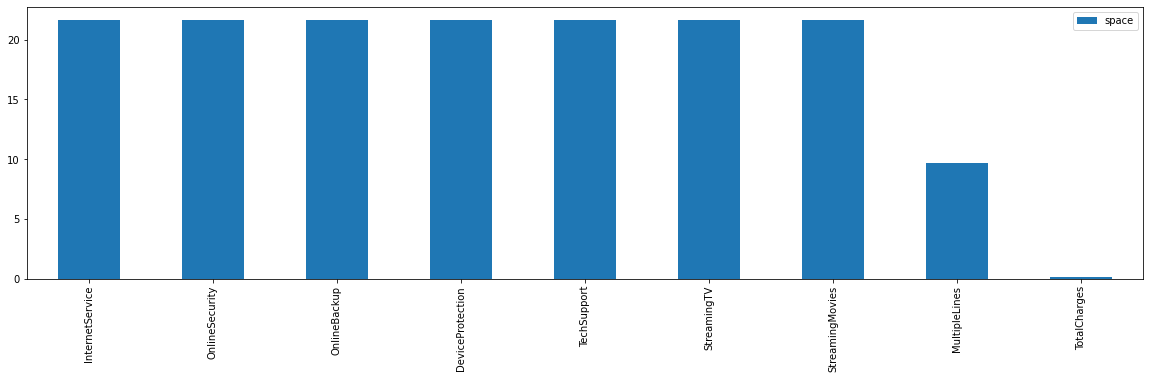

In [11]:
pass_value(df)

In [12]:
missing_values_count = df.isnull().sum()
missing_values_count

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

## Предобработка данных

### Обработка пропусков и типов данных

Преобразуем формат столбцов с датой и выделим целевой признак

In [13]:
# Введем столбец с целевым признаком
df['churn'] = np.where(df.EndDate == 'No', 0, 1)

Если клиент до сих пор является клиентом, заполним столбец `EndDate` датой среза данных: `2020-02-01 00:00:00`

In [14]:
df.loc[(df.EndDate == 'No'), 'EndDate'] = '2020-02-01 00:00:00'
df.BeginDate = df.BeginDate.astype('datetime64')
df.EndDate = df.EndDate.astype('datetime64')

Введем новый признак - timedelta (время, в течение которого абонент является клиентом). 

In [15]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
churn                  0
dtype: int64

In [16]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [17]:
df = df[df['TotalCharges'].notna()]

In [18]:
df['timedelta_days'] = (df.EndDate - df.BeginDate).dt.days

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   5512 non-null   object        
 9   OnlineSecurity    5512 non-null   object        
 10  OnlineBackup      5512 non-null   object        
 11  DeviceProtection  5512 non-null   object        
 12  TechSupport       5512 non-null   object        
 13  StreamingTV       5512 non-null   object        
 14  StreamingMovies   5512 n

In [20]:
df['timedelta_days'] = df['timedelta_days'].astype('int')
df['MonthlyCharges'] = df['MonthlyCharges'].astype('int')
df['TotalCharges'] = df['TotalCharges'].astype('int')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('int')
df['churn'] = df['churn'].astype('int')

In [21]:
# Выбросим ненужные столбцы
df = df.drop(['BeginDate', 'EndDate', 'customerID'], axis=1)

In [22]:
df.isna().sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        680
churn                  0
timedelta_days         0
dtype: int64

Пропуски в столбцах конкретных услуг означают, что клиент данной услугой не пользуется, поэтому заменим их на `"No"`.

In [23]:
df = df.fillna('No')

In [24]:
df.head(2)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,churn,timedelta_days
0,Month-to-month,Yes,Electronic check,29,29,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,0,31
1,One year,No,Mailed check,56,1889,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0,1036


Пропуски обнаружены в 8 столбцах. В 7 из них одинаковое количество пропусков (данные о доп. услугах). <br>
Вероятные причины этих пропусков:
- В тарифах абонентов априори отсутствует возможность подключения данных услуг.<br>
- Абонент попал в базу до того, как ввели данные услуги. 

### Корреляционный анализ

In [36]:
df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'churn', 'timedelta_days']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,churn,timedelta_days
Type,1.0000,0.1062,0.2775,0.3914,0.5076,0.5038,0.1522,0.0990,0.1378,0.1802,0.0671,0.0704,0.0000,0.0858,0.1793,0.1461,0.0658,0.2513,0.6670
PaperlessBilling,0.1062,1.0000,0.3689,0.4677,0.2052,0.2311,0.0000,0.1969,0.1612,0.0554,0.3441,0.3254,0.0000,0.2417,0.0105,0.1706,0.2533,0.2952,0.0000
PaymentMethod,0.2775,0.3689,1.0000,0.3987,0.3499,0.3230,0.2617,0.2822,0.3067,0.2709,0.3772,0.3784,0.0000,0.2920,0.2447,0.2229,0.3400,0.4486,0.3736
MonthlyCharges,0.3914,0.4677,0.3987,1.0000,0.7654,0.9192,0.5485,0.6298,0.6666,0.5750,0.8324,0.8312,0.0000,0.3078,0.2005,0.1818,0.6750,0.3588,0.4108
TotalCharges,0.5076,0.2052,0.3499,0.7654,1.0000,0.5080,0.5457,0.6561,0.6722,0.5672,0.6604,0.6660,0.0000,0.1484,0.4247,0.1181,0.6064,0.2810,0.8421
InternetService,0.5038,0.2311,0.3230,0.9192,0.5080,1.0000,0.2409,0.2332,0.2325,0.2391,0.2726,0.2726,0.0000,0.1605,0.0000,0.1073,0.2256,0.1959,0.0129
OnlineSecurity,0.1522,0.0000,0.2617,0.5485,0.5457,0.2409,1.0000,0.4296,0.4177,0.5278,0.2711,0.2891,0.0168,0.0569,0.2220,0.1246,0.1526,0.2646,0.4250
OnlineBackup,0.0990,0.1969,0.2822,0.6298,0.6561,0.2332,0.4296,1.0000,0.4575,0.4444,0.4273,0.4172,0.0073,0.1022,0.2198,0.0315,0.3114,0.1271,0.4664
DeviceProtection,0.1378,0.1612,0.3067,0.6666,0.6722,0.2325,0.4177,0.4575,1.0000,0.4986,0.5743,0.5901,0.0000,0.0908,0.2377,0.0102,0.3106,0.1016,0.4675
TechSupport,0.1802,0.0554,0.2709,0.5750,0.5672,0.2391,0.5278,0.4444,0.4986,1.0000,0.4215,0.4252,0.0000,0.0925,0.1863,0.0966,0.1555,0.2547,0.4240


Исследуем на корреляцию количественные признаки

In [28]:
numeric = ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'churn', 'timedelta_days']

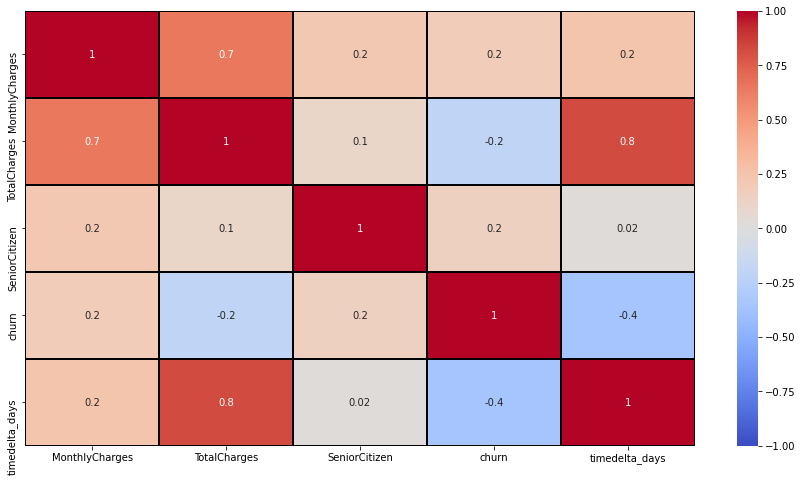

In [29]:
import seaborn as sns
corr = df[numeric].corr(method="pearson")

fig, ax = plt.subplots(figsize = (15,8))

ax = sns.heatmap(corr, 
                 annot=True, 
                 fmt = '.1g',
                 vmin=-1, vmax=1, center= 0,
                 cmap='coolwarm',
                 linewidths=1, linecolor='black')

In [30]:
# Image('./img/corr.jpg')

По шкале Чеддока высокая корреляция установлена между:
- `TotalCharges` и `timedelta_days` = 0.8
<br>

Предположительно зависимость между `MonthlyCharges` и сервисвми связана с увеличением стоимости от количества доп. услуг.
Также видим высокую корреляцию между `TotalCharges` и "временем лояльности клиента" = 0.83. 
<br>
Уберем столбец `TotalCharges`.

In [31]:
df_clean = df.drop(['TotalCharges'], axis=1)

### Кодирование, семплирование, масштабирование

In [37]:
# Разделяем датасет на тренировочную и тестовую выборки в соотношении 75/25
X = df_clean.drop('churn', axis=1)
y = df_clean['churn']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = \
train_test_split(X, y,
                test_size=.25,
                random_state=rs,
                stratify=y)
X_train_columns = X_train_clean.columns

In [38]:
object_cols = [i for i in df.dtypes[df.dtypes == 'object'].index]
object_cols

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'gender',
 'Partner',
 'Dependents',
 'MultipleLines']

In [39]:
OHE = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_OHE_cols = pd.DataFrame(OHE.fit_transform(X_train_clean[object_cols]))
X_test_OHE_cols = pd.DataFrame(OHE.transform(X_test_clean[object_cols]))

In [40]:
names_of_columns = OHE.get_feature_names(object_cols)

In [41]:
# Train sample encoding
X_train_OHE_cols.index = X_train_clean.index
X_train_OHE_cols.columns = names_of_columns

num_train = X_train_clean.drop(object_cols, axis=1)


OHE_train = pd.concat([num_train, X_train_OHE_cols], axis=1)

OHE_train.info()

OHE_train = OHE_train.astype('int')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 1471 to 1638
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   MonthlyCharges                           5274 non-null   int64  
 1   SeniorCitizen                            5274 non-null   int64  
 2   timedelta_days                           5274 non-null   int64  
 3   Type_Month-to-month                      5274 non-null   float64
 4   Type_One year                            5274 non-null   float64
 5   Type_Two year                            5274 non-null   float64
 6   PaperlessBilling_No                      5274 non-null   float64
 7   PaperlessBilling_Yes                     5274 non-null   float64
 8   PaymentMethod_Bank transfer (automatic)  5274 non-null   float64
 9   PaymentMethod_Credit card (automatic)    5274 non-null   float64
 10  PaymentMethod_Electronic check           5274

In [42]:
# Test sample encoding
X_test_OHE_cols.index = X_test_clean.index
X_test_OHE_cols.columns = names_of_columns

num_test = X_test_clean.drop(object_cols, axis=1)


OHE_test = pd.concat([num_test, X_test_OHE_cols], axis=1)

OHE_test.info()

OHE_test = OHE_test.astype('int')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758 entries, 2506 to 5808
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   MonthlyCharges                           1758 non-null   int64  
 1   SeniorCitizen                            1758 non-null   int64  
 2   timedelta_days                           1758 non-null   int64  
 3   Type_Month-to-month                      1758 non-null   float64
 4   Type_One year                            1758 non-null   float64
 5   Type_Two year                            1758 non-null   float64
 6   PaperlessBilling_No                      1758 non-null   float64
 7   PaperlessBilling_Yes                     1758 non-null   float64
 8   PaymentMethod_Bank transfer (automatic)  1758 non-null   float64
 9   PaymentMethod_Credit card (automatic)    1758 non-null   float64
 10  PaymentMethod_Electronic check           1758

In [43]:
display(OHE_train.head(2),
        OHE_train.shape,
        OHE_test.head(2),
        OHE_test.shape)

,MonthlyCharges,SeniorCitizen,timedelta_days,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,MultipleLines_Yes
1471,88,0,945,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1
2139,66,0,215,1,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0


(5274, 35)

,MonthlyCharges,SeniorCitizen,timedelta_days,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,MultipleLines_Yes
2506,24,1,2191,0,0,1,1,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1
3031,71,1,1522,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0


(1758, 35)

Семплируем выборку

In [36]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
    
X_upsampled_clean, y_upsampled_clean = upsample(X_train_clean, y_train_clean, 10)

In [37]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

X_downsampled_clean, y_downsampled_clean = downsample(X_train_clean, y_train_clean, 0.1)

Масштабируем признаки

In [44]:
scaler = StandardScaler() 

scaler.fit(OHE_train)
X_train_clean = scaler.transform(OHE_train)
X_test_clean = scaler.transform(OHE_test)

## Обучение моделей

### Подбор параметров

Обучим две разных модели, рещающие задачу классификации: *модель бустинга (catboost)* и *модель решающих деревьев (randomforest)*

In [45]:
RF_model = RandomForestClassifier(random_state=rs)
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 15, 1)}
grid = GridSearchCV(RF_model, parametrs, cv=5, scoring = 'roc_auc')

In [47]:
%%time
grid.fit(X_train_clean, y_train_clean)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'max_depth': 7, 'n_estimators': 50}
0.8552010806527255
RandomForestClassifier(max_depth=7, n_estimators=50, random_state=120922)
CPU times: user 29.8 s, sys: 86.8 ms, total: 29.9 s
Wall time: 29.9 s


In [48]:
RF_model = grid.best_estimator_

AUC-ROC =  0.8914238329835771


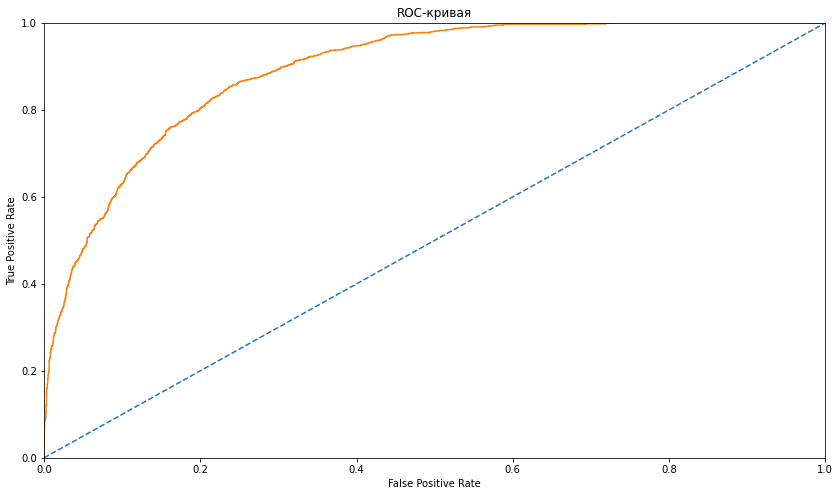

In [49]:
RF_model.fit(X_train_clean, y_train_clean)
probabilities_valid = RF_model.predict_proba(X_train_clean)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(y_train_clean,probabilities_one_valid)
print("AUC-ROC = ",auc_roc)

fig, ax = plt.subplots(figsize=(14,8))
fpr, tpr, thresholds = roc_curve(y_train_clean, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [50]:
CatBoostModel = CatBoostClassifier(random_state=rs)
GridSearchCatBoost = GridSearchCV(CatBoostModel,{
    'iterations': [1000, 1200],
    'learning_rate': [0.03],
    'depth' : [6, 8],
    'verbose' : [True]
}, cv = 5,scoring = 'roc_auc')

In [51]:
%%time
GridSearchCatBoost.fit(X_train_clean, y_train_clean)
print(GridSearchCatBoost.best_params_)
print(GridSearchCatBoost.best_score_)
print(GridSearchCatBoost.best_estimator_)

0:	learn: 0.6719087	total: 48.9ms	remaining: 48.8s
1:	learn: 0.6518003	total: 51.4ms	remaining: 25.6s
2:	learn: 0.6327208	total: 53.7ms	remaining: 17.8s
3:	learn: 0.6162407	total: 55.9ms	remaining: 13.9s
4:	learn: 0.6000398	total: 58.3ms	remaining: 11.6s
5:	learn: 0.5846045	total: 60.5ms	remaining: 10s
6:	learn: 0.5725482	total: 62.7ms	remaining: 8.9s
7:	learn: 0.5588483	total: 64.9ms	remaining: 8.05s
8:	learn: 0.5477454	total: 67.1ms	remaining: 7.38s
9:	learn: 0.5371662	total: 69.1ms	remaining: 6.84s
10:	learn: 0.5285992	total: 71.3ms	remaining: 6.41s
11:	learn: 0.5188800	total: 73.6ms	remaining: 6.06s
12:	learn: 0.5107603	total: 75.9ms	remaining: 5.76s
13:	learn: 0.5032733	total: 78.1ms	remaining: 5.5s
14:	learn: 0.4976392	total: 80.3ms	remaining: 5.28s
15:	learn: 0.4917835	total: 82.6ms	remaining: 5.08s
16:	learn: 0.4853737	total: 84.8ms	remaining: 4.9s
17:	learn: 0.4794538	total: 86.9ms	remaining: 4.74s
18:	learn: 0.4739919	total: 89.2ms	remaining: 4.6s
19:	learn: 0.4692928	total: 

In [52]:
CatBoostModel = GridSearchCatBoost.best_estimator_
CatBoostModel.fit(X_train_clean, y_train_clean, verbose = True)
cat_Proba_clean = CatBoostModel.predict_proba(X_train_clean)[:,1]
roc_auc_score(y_train_clean, cat_Proba_clean)

0:	learn: 0.6720278	total: 2.75ms	remaining: 3.3s
1:	learn: 0.6524962	total: 5.5ms	remaining: 3.29s
2:	learn: 0.6330334	total: 7.91ms	remaining: 3.15s
3:	learn: 0.6164552	total: 10.7ms	remaining: 3.19s
4:	learn: 0.6009216	total: 13.3ms	remaining: 3.17s
5:	learn: 0.5855334	total: 16.7ms	remaining: 3.32s
6:	learn: 0.5728894	total: 19.3ms	remaining: 3.29s
7:	learn: 0.5582982	total: 21.7ms	remaining: 3.24s
8:	learn: 0.5473785	total: 24.2ms	remaining: 3.2s
9:	learn: 0.5369843	total: 26.6ms	remaining: 3.16s
10:	learn: 0.5281734	total: 28.9ms	remaining: 3.12s
11:	learn: 0.5185359	total: 31.3ms	remaining: 3.1s
12:	learn: 0.5101879	total: 33.7ms	remaining: 3.07s
13:	learn: 0.5028948	total: 36.1ms	remaining: 3.06s
14:	learn: 0.4956454	total: 38.5ms	remaining: 3.04s
15:	learn: 0.4890477	total: 41ms	remaining: 3.03s
16:	learn: 0.4836131	total: 43.3ms	remaining: 3.02s
17:	learn: 0.4779863	total: 45.9ms	remaining: 3.01s
18:	learn: 0.4731270	total: 48.3ms	remaining: 3s
19:	learn: 0.4685955	total: 50.

0.9829407295952654

### На семплированных выборках

In [49]:
# CatBoostModel = GridSearchCatBoost.best_estimator_
# CatBoostModel.fit(X_downsampled_clean, y_downsampled_clean, verbose = True)
# cat_Proba_clean = CatBoostModel.predict_proba(X_train_clean)[:,1]
# roc_auc_score(y_train_clean, cat_Proba_clean)

In [50]:
# CatBoostModel = GridSearchCatBoost.best_estimator_
# CatBoostModel.fit(X_upsampled_clean, y_upsampled_clean, verbose = True)
# cat_Proba_clean = CatBoostModel.predict_proba(X_train_clean)[:,1]
# roc_auc_score(y_train_clean, cat_Proba_clean)

### Features importance

timedelta_days                 49.9691
MonthlyCharges                 11.0133
Type_Month-to-month             4.5601
InternetService_Fiber optic     2.6762
Type_Two year                   2.0821
                                ...   
OnlineBackup_Yes                0.7838
StreamingMovies_Yes             0.7664
OnlineBackup_No                 0.7091
StreamingTV_No                  0.5876
DeviceProtection_No             0.4732
Length: 35, dtype: float64


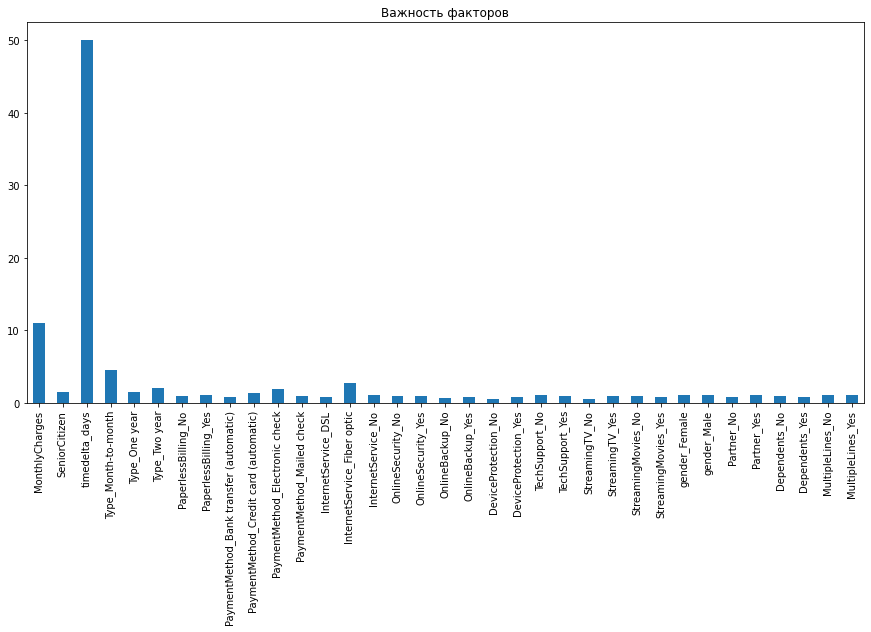

In [53]:
xtrain_cols = OHE_train.columns
importances = CatBoostModel.feature_importances_
importances = pd.Series(importances, index=xtrain_cols)
print(importances.sort_values(ascending = False))
fig = plt.subplots(figsize=(15,7))
importances.plot(kind='bar',title = 'Важность факторов');

In [54]:
low_importance = [i for i in importances.index if importances[i] < 1]
low_importance

['PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Mailed check',
 'InternetService_DSL',
 'OnlineSecurity_No',
 'OnlineSecurity_Yes',
 'OnlineBackup_No',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'DeviceProtection_Yes',
 'TechSupport_Yes',
 'StreamingTV_No',
 'StreamingTV_Yes',
 'StreamingMovies_No',
 'StreamingMovies_Yes',
 'Partner_No',
 'Dependents_No',
 'Dependents_Yes']

In [55]:
X_train_new = OHE_train.drop(low_importance, axis=1)
X_test_new = OHE_test.drop(low_importance, axis=1)

In [56]:
scaler.fit(X_train_new)
X_train_new = scaler.transform(X_train_new)
X_test_new = scaler.transform(X_test_new)

Попробуем обучить наши две модели на лучших параметрах только на важных признаках.

In [57]:
CatBoostModel = GridSearchCatBoost.best_estimator_
CatBoostModel.fit(X_train_new, y_train_clean, verbose=True)
cat_Proba = CatBoostModel.predict_proba(X_train_new)[:,1]
print('roc_auc:', round(roc_auc_score(y_train_clean, cat_Proba), 2))
prediction = CatBoostModel.predict(X_train_new)
print('accuracy:', round(accuracy_score(y_train_clean,prediction), 2))

0:	learn: 0.6708535	total: 2.27ms	remaining: 2.73s
1:	learn: 0.6516561	total: 4.61ms	remaining: 2.76s
2:	learn: 0.6342959	total: 6.1ms	remaining: 2.43s
3:	learn: 0.6178096	total: 8.09ms	remaining: 2.42s
4:	learn: 0.6008730	total: 10ms	remaining: 2.4s
5:	learn: 0.5857143	total: 12ms	remaining: 2.39s
6:	learn: 0.5724660	total: 13.9ms	remaining: 2.38s
7:	learn: 0.5601216	total: 15.9ms	remaining: 2.37s
8:	learn: 0.5489208	total: 17.8ms	remaining: 2.36s
9:	learn: 0.5391144	total: 19.8ms	remaining: 2.35s
10:	learn: 0.5292660	total: 21.8ms	remaining: 2.35s
11:	learn: 0.5210883	total: 23.7ms	remaining: 2.35s
12:	learn: 0.5132503	total: 25.7ms	remaining: 2.34s
13:	learn: 0.5055281	total: 27.6ms	remaining: 2.34s
14:	learn: 0.4977870	total: 29.6ms	remaining: 2.34s
15:	learn: 0.4902479	total: 31.6ms	remaining: 2.34s
16:	learn: 0.4836988	total: 33.5ms	remaining: 2.33s
17:	learn: 0.4784660	total: 35.4ms	remaining: 2.32s
18:	learn: 0.4737312	total: 37.4ms	remaining: 2.32s
19:	learn: 0.4690899	total: 

На важных признаках результат выше. Время протестировать итоговую модель

## Тестирование

In [58]:
CatBoostModel = GridSearchCatBoost.best_estimator_
cat_Proba = CatBoostModel.predict_proba(X_test_new)[:,1]
print('roc_auc:', round(roc_auc_score(y_test_clean, cat_Proba), 4))
prediction = CatBoostModel.predict(X_test_new)
print('accuracy:', round(accuracy_score(y_test_clean,prediction), 4))

roc_auc: 0.9212
accuracy: 0.8811


## Результаты и выводы

AUC-ROC =  0.92


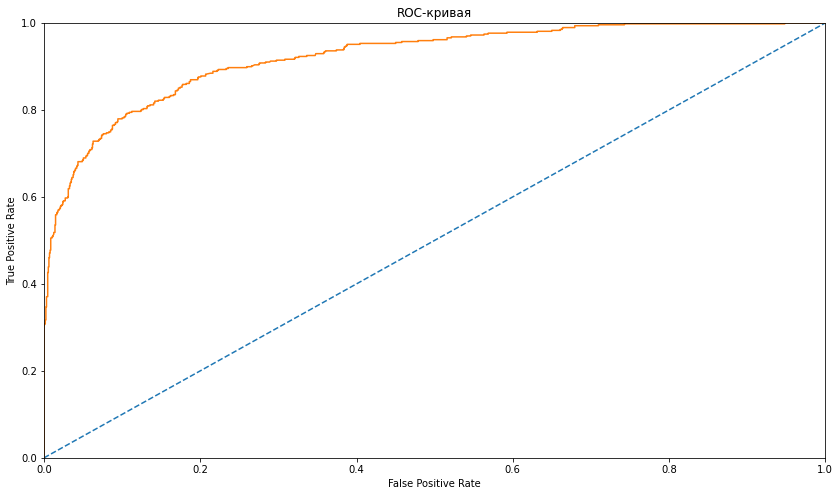

In [59]:
probabilities_valid = CatBoostModel.predict_proba(X_test_new)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(y_test_clean,probabilities_one_valid)
print("AUC-ROC = ", round(auc_roc, 2))

fig, ax = plt.subplots(figsize=(14,8))
fpr, tpr, thresholds = roc_curve(y_test_clean, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

# roc_auc = 0,92
# accuracy = 0,88

In [60]:
print(classification_report(y_test_clean, prediction))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1291
           1       0.85      0.67      0.75       467

    accuracy                           0.88      1758
   macro avg       0.87      0.81      0.84      1758
weighted avg       0.88      0.88      0.88      1758



**1. Предобработка данных**.<br><br>
В результате настоящего исследования: 
- 1.1. Были проведены работы по обработке пропущенных значений, приведению данных к корректному типу;
- 1.2. Проведен исследовательский анализ данных на предмет корреляции, выбросов и взаимосвязей;
- 1.3. С помощью кодирования (OneHotEncoder) предобработаны категориальные признаки;
- 1.4. Устранен дисбаланс классов и проведено масштабирование признаков;
- 1.5. Выделен целевой признак для построения модели и разделены выборки на обучающую и тестовую в соотношении 75/25.

**2. Подбор модели**<br><br>

- 2.1. С помощью кроссвалидации и были подобраны гиперпараметры для и обучены модели: <br>
    - **Решающих деревьев** {'max_depth': 7, 'n_estimators': 50}, результат = **0.85** <br> 
    - **Градиентного Бустинга** {'depth': 6, 'iterations': 1000, 'learning_rate': 0.03, 'verbose': True} результат = **0.91**. <br><br>
    
Были применены методы семплирования для обучающей выборки, однако лучших результатов не показали.
Была проведена оценка важности признаков и оставлены признаки с весом > 1. Результат модели Градиентного Бустинга на трейне вырос до 0.98.

**3. Итоговая модель**<br><br>
Для тестирования на основе лучшего результата метрики ROC-AUC была выбрана модель градиентного бустинга CatBoostClassifier. Результаты на тестовой выборке:
- roc_auc = 0,92
- accuracy = 0,88

## Отчет

### Какие пункты плана были выполнены, а какие — нет (поясните почему)? <br><br> Какие ключевые шаги в решении задачи выделили?
В процессе работы были выполнены все пункты плана, а именно:

- данные были предобработаны и подготовлены к обучению

**Данные**: 4 таблицы в формате .csv были объединены в один датафрейм. Пустые значения были предобработаны путем заполнения пустых строк значением `No` в следствие предположения, что пропуски образовались из-за того, что конкретные пользователи не пользуются данными услугами либо данные попали в датасет, когда данная услуга не подключалась априори.

На данном этапе нами была выделена новая переменная `timedelta_days` (сколько в днях клиент пользуется услугами оператора) из двух ранее присутствующих переменных `BeginDate` и `EndDdate`. При это значения переменных `BeginDate` и `EndDdate` были удалены. Также отдельно была выделена переменная `churn` (отток клиентов).

В процессе корреляционного анализа было выявлено, что переменные `TotalCharges` и `timedelta_days` мультколиинеарны. Переменная `TotalCharges` была удалена.

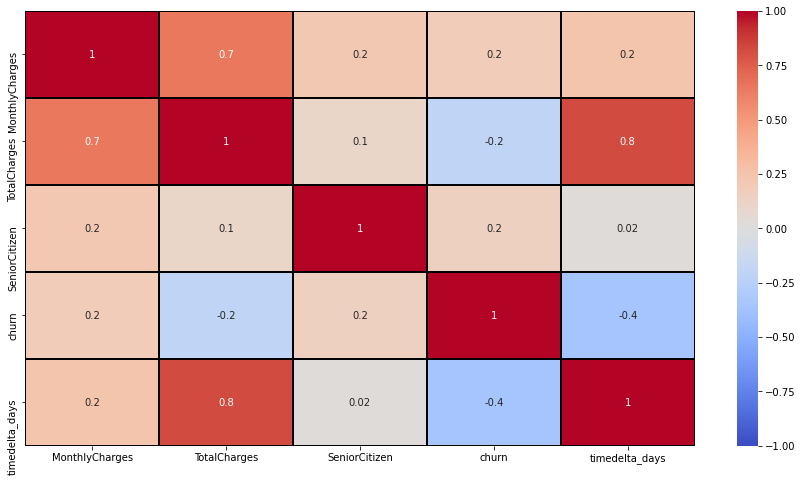

In [61]:
import seaborn as sns
corr = df[numeric].corr(method="pearson")

fig, ax = plt.subplots(figsize = (15,8))

ax = sns.heatmap(corr, 
                 annot=True, 
                 fmt = '.1g',
                 vmin=-1, vmax=1, center= 0,
                 cmap='coolwarm',
                 linewidths=1, linecolor='black')

- Категориальные признаки были преобразоаны в числовые с помощью кодирования OneHotEncoding.

- Были подготовлены уменьшенные и увеличенные выборки для проверки гипотезы о том, что увеличенные или уменьшенные данные дадут прирост качества модели.

- Были подобраны модели и параметры к ним и выбрана наиболее оптимальная модель для обучения

- Рассматривались модели RandomForestClassifier() и CatBoostClassifier(). Гиперпарметры подбирались с помощью GridSearchCV. Лучшие результаты ROC AUC показала модель CatBoostClassifier(), а именно 0.91.

Проверка итоговой модели на уменьшенном и увеличенном количестве данных не дало улучшение качества модели, метрика ROC-AUC снизилась: на уменьшенном и на увеличенном ROC AUC был примерно 0,8.

Были проанализированы какие факторы сильнее всего влияют на качество модели. Самые *важные* факторы:

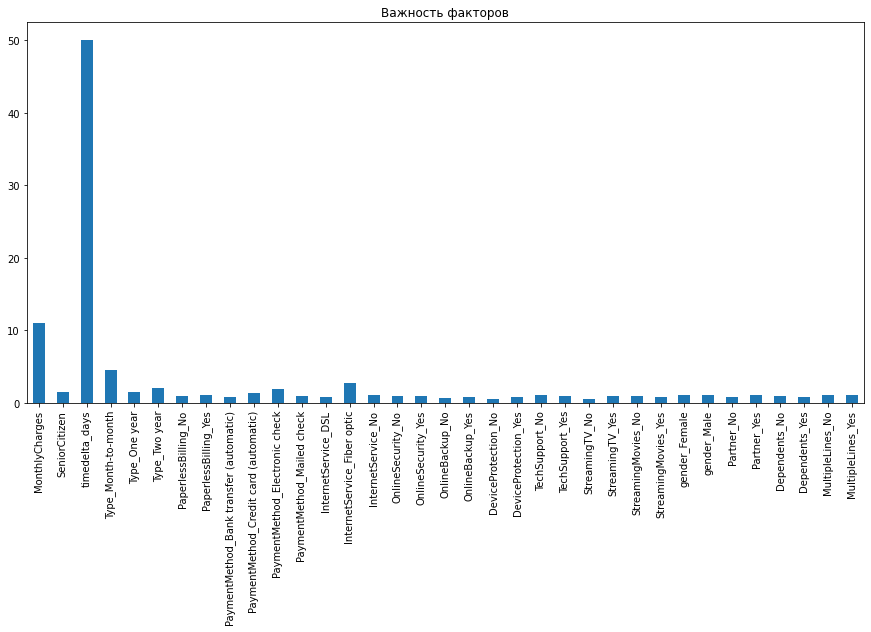

In [65]:
fig = plt.subplots(figsize=(15,7))
importances.plot(kind='bar',title = 'Важность факторов');

Удалили *неважные* факторы и снова попробовали обучить модель и подобрать гиперпараметры и получили лучшие результаты, о которых ниже

### Какая ваша итоговая модель и какое у неё качество?

# roc_auc = 0,91
# accuracy = 0,87

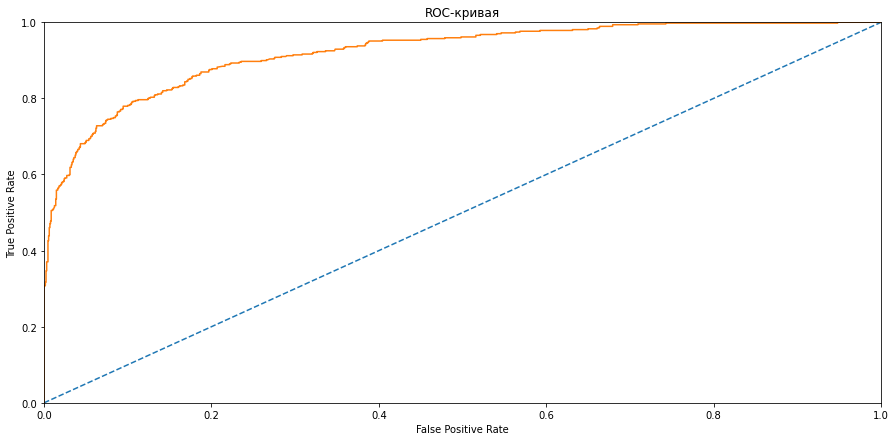

In [67]:
fig = plt.subplots(figsize=(15,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

☔☔☔